In [1]:
import numpy as np
import arepo
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
import h5py as h5

import re
import astropy.units as u

time_conv = 977.79222167

In [2]:
sim_list = ['phantom-vacuum-grav', 'phantom-vacuum', 'phantom-Sg10-Rc4.0', 'phantom-vacuum-Sg10-Rc4.0',
            'phantom-vacuum-Sg20-Rc4.0', 'Nbody', 'phantom-vacuum-Sg20-Rc3.5']

def read_snap(idx, sim_idx, lvl='lvl3', parttype=[0], fields=['Coordinates', 'Masses', 'Velocities'],
              basepath = '/n/holyscratch01/hernquist_lab/abeane/starbar_runs/runs/'):
    fname = basepath + sim_list[sim_idx] + '/' + lvl + '/output'
    return arepo.Snapshot(fname, idx, parttype=parttype, fields=fields, combineFiles=True)

def read_sfr(sim_idx, lvl='lvl3', basepath = '/n/holyscratch01/hernquist_lab/abeane/starbar_runs/runs/'):
    fname = basepath + sim_list[sim_idx] + '/' + lvl + '/output/sfr.txt'
    return np.genfromtxt(fname)

def read_fourier(sim_idx, lvl='lvl3', basepath='/n/home01/abeane/starbar/plots/'):
    sim = sim_list[sim_idx]
    f = h5.File(basepath+'/fourier_component/data/fourier_'+sim+'-'+lvl+'.hdf5', mode='r')
    return f




In [3]:
# sn0_list = []
# sn2_list = []
# sn3_list = []
# sn4_list = []
sn5_list = []
sn6_list = []
sn6i_list = []
# idx_list = [0, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800]#, 100, 125]
idx_list = np.arange(0, 801, 100)
fields=['Coordinates', 'Velocities', 'Masses', 'Acceleration']
for idx in tqdm(idx_list):
#     sn0 = read_snap(idx, 0, parttype=None, fields=None)
#     sn0_list.append(sn0)
    
#     sn2 = read_snap(idx, 2, parttype=None, fields=None)
#     sn2_list.append(sn2)
    
#     sn3 = read_snap(idx, 3, parttype=None, fields=None)
#     sn3_list.append(sn3)
    
#     sn4 = read_snap(idx, 4, parttype=None, fields=None)
#     sn4_list.append(sn4)

    sn5 = read_snap(idx, 5, parttype=None, fields=fields)
    sn5_list.append(sn5)

    try:
        sn6 = read_snap(idx, 6, parttype=None, fields=fields)
        sn6_list.append(sn6)
    except:
        pass

    try:
        sn6i = read_snap(idx, 6, lvl='lvl3-isotherm', parttype=None, fields=None)
        sn6i_list.append(sn6i)
    except:
        pass



A Jupyter Widget

In [4]:
# sfr0 = read_sfr(0)
# sfr1 = read_sfr(1)
sfr2 = read_sfr(2)
sfr3 = read_sfr(3)
sfr4 = read_sfr(4)
sfr6 = read_sfr(6)

# fourier3 = read_fourier(3)
fourier4 = read_fourier(4)
fourierN = read_fourier(5)
fourier6 = read_fourier(6)
fourier6i = read_fourier(6, lvl='lvl3-isotherm')

In [5]:
def compute_angmom(sn, ntype=6, center=np.array([200, 200, 200])):
    ang_mom_tot = np.zeros((ntype, 3))
    
    for i in range(ntype):
        if sn.NumPart_Total[i] > 0:
#             print('doing', i)
            part = getattr(sn, 'part'+str(i))
            pos = part.Coordinates.value - center
            vel = part.Velocities.value
            if hasattr(part, 'Masses'):
                mom = vel * part.Masses.reshape((sn.NumPart_Total[i], 1))
            else:
                mom = vel * sn.MassTable[i]
                
#             print(vel[0])
#             print(mom[0])
            
            # compute z component of angular momentum
#             ang_mom = pos[:,0]*mom[:,1] - mom[:,0] * pos[:,1]
            ang_mom = np.cross(pos, mom)
    
#             print(np.sum(ang_mom))
            ang_mom_tot[i] = np.sum(ang_mom, axis=0)
    
    return ang_mom_tot

def compute_angmom_bar(sn, ntype=6, center=np.array([200, 200, 200]), bar_Lz=400):
    ang_mom_tot = np.zeros(ntype)
    
    for i in range(ntype):
        if sn.NumPart_Total[i] > 0:
#             print('doing', i)
            part = getattr(sn, 'part'+str(i))
            pos = part.Coordinates.value - center
            vel = part.Velocities.value
            if hasattr(part, 'Masses'):
                mom = vel * part.Masses.reshape((sn.NumPart_Total[i], 1))
            else:
                mom = vel * sn.MassTable[i]
                
#             print(vel[0])
#             print(mom[0])
            
            # compute z component of angular momentum
            ang_mom = pos[:,0]*mom[:,1] - mom[:,0] * pos[:,1]
            
            if i ==2:
                cyl = get_cyl(sn, 2, center=center)
                R = cyl[:,0]
                vphi = cyl[:,4]
                bar_key = R * vphi < bar_Lz
                disk_key = np.logical_not(bar_key)
                
                ang_mom_bar = ang_mom[bar_key]
                ang_mom_disk = ang_mom[disk_key]
                
                ang_mom_tot[2] = np.sum(ang_mom_disk)
                ang_mom_tot[5] = np.sum(ang_mom_bar)
            else:
            
#             print(np.sum(ang_mom))
                ang_mom_tot[i] = np.sum(ang_mom)
    
    return ang_mom_tot

def compute_mominertia(sn, ntype=6, center=np.array([200, 200, 200])):
    mominert_tot = np.zeros(ntype)
    
    for i in range(ntype):
        if sn.NumPart_Total[i] > 0:
#             print('doing', i)
            part = getattr(sn, 'part'+str(i))
            pos = part.Coordinates.value - center
            if hasattr(part, 'Masses'):
                mass = part.Masses.value
            else:
                mass = np.full(sn.NumPart_Total[i], sn.MassTable[i])
                
            
            R = np.linalg.norm(pos[:,:2], axis=1)
            
            mominert_tot[i] = np.sum(mass * R * R)
    
    return mominert_tot

def get_cyl(sn, pt, center=np.array([200, 200, 200])):
    part = getattr(sn, 'part'+str(pt))
    pos = part.pos.value - center
    vel = part.vel.value
    
    R = np.linalg.norm(pos[:,:2], axis=1)
    phi = np.arctan2(pos[:,1], pos[:,0])
    z = pos[:,2]
    
    cosphi = pos[:,0]/R
    sinphi = pos[:,1]/R
    
    vR = cosphi * vel[:,0] + sinphi * vel[:,1]
    vphi = cosphi * vel[:,1] - sinphi * vel[:,0]
    vz = vel[:,2]
    
    return np.transpose([R, phi, z, vR, vphi, vz])
    

In [6]:
def extract_t_A2A0(fourier, idx):

    i = 0

    tlist = np.array(fourier['time'])
    A2A0list = []
    print(fourier['snapshot_000']['Rlist'][idx])
    while 'snapshot_'+"{:03d}".format(i) in fourier.keys():
        key = 'snapshot_'+"{:03d}".format(i)
        A0 = fourier[key]['A0'][idx]
        A2r = fourier[key]['A2r'][idx]
        A2i = fourier[key]['A2i'][idx]
    
        A2 = np.sqrt(A2r*A2r + A2i*A2i)
        A2A0list.append(A2/A0)
        i += 1
    
    return np.array(tlist), np.array(A2A0list)

def extract_t_max_A2A0(fourier):

    i = 0

    tlist = np.array(fourier['time'])
    A2A0list = []
    print(fourier['snapshot_000']['Rlist'][idx])
    while 'snapshot_'+"{:03d}".format(i) in fourier.keys():
        key = 'snapshot_'+"{:03d}".format(i)
        A0 = np.array(fourier[key]['A0'])
        A2r = np.array(fourier[key]['A2r'])
        A2i = np.array(fourier[key]['A2i'])
    
        A2 = np.sqrt(A2r*A2r + A2i*A2i)
#         A2A0 = A2/A0
        A2A0list.append(np.max(A2/A0))
#         A2A0list.append(A2/A0)
        i += 1
    
    return np.array(tlist), np.array(A2A0list)

def extract_t_AmA0(fourier, idx, m):

    i = 0

    tlist = np.array(fourier['time'])
    AmA0list = []
#     print(fourier['snapshot_000']['Rlist'][idx])
    while 'snapshot_'+"{:03d}".format(i) in fourier.keys():
        key = 'snapshot_'+"{:03d}".format(i)
        A0 = fourier[key]['A0'][idx]
        Amr = fourier[key]['A'+str(m)+'r'][idx]
        Ami = fourier[key]['A'+str(m)+'i'][idx]
    
        Am = np.sqrt(Amr*Amr + Ami*Ami)
        AmA0list.append(Am/A0)
        i += 1
    
    return np.array(tlist), np.array(AmA0list)

def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

In [7]:
def get_bar_angle(phi, firstkey):
    out = np.zeros(len(phi))

    # set the first bar angle
    first_bar_angle = phi[firstkey]/2.0
    out[firstkey] = first_bar_angle
    
    # set all subsequent angles
    for i in np.arange(firstkey+1, len(out)):
        dphi = phi[i] - phi[i-1]
        if dphi < 0:
            dphi += 2.*np.pi
        out[i] = out[i-1] + dphi/2.0

    # set all previous angles to be the bar angle
    for i in np.arange(0, firstkey):
        out[i] = first_bar_angle

    return out

def get_sorted_keys(dat):
    keys = list(dat.keys())
    # only keep keys that are snapshot keys
    keys = [k for k in keys if 'snapshot' in k]

    # extract and sort indices
    indices = [int(re.findall(r'\d?\d?\d\d\d', k)[0]) for k in keys]
    sorted_arg = np.argsort(indices)
    keys_sorted = [keys[i] for i in sorted_arg]

    return keys_sorted

def get_A2_angle(dat, keys, Rbin):
    Rlist = np.array([np.array(dat[k]['Rlist']) for k in keys])
    A2r = np.array([np.array(dat[k]['A2r']) for k in keys])
    A2i = np.array([np.array(dat[k]['A2i']) for k in keys])
    phi = np.arctan2(A2i, A2r)
    phi = phi[:,Rbin]
    R_at_Rbin = Rlist[:,Rbin]
    
    time = np.array(dat['time'])

    return time, R_at_Rbin, phi

def get_bar_length(dat, keys, Rmin=2, Rmax=10, ratio_cut = 2):
    Rlist = np.array([np.array(dat[k]['Rlist']) for k in keys])

    A0 = np.array([np.array(dat[k]['A0']) for k in keys])
    A1r = np.array([np.array(dat[k]['A1r']) for k in keys])
    A1i = np.array([np.array(dat[k]['A1i']) for k in keys])
    A2r = np.array([np.array(dat[k]['A2r']) for k in keys])
    A2i = np.array([np.array(dat[k]['A2i']) for k in keys])
    A3r = np.array([np.array(dat[k]['A3r']) for k in keys])
    A3i = np.array([np.array(dat[k]['A3i']) for k in keys])
    A4r = np.array([np.array(dat[k]['A4r']) for k in keys])
    A4i = np.array([np.array(dat[k]['A4i']) for k in keys])
    A5r = np.array([np.array(dat[k]['A5r']) for k in keys])
    A5i = np.array([np.array(dat[k]['A5i']) for k in keys])
    A6r = np.array([np.array(dat[k]['A6r']) for k in keys])
    A6i = np.array([np.array(dat[k]['A6i']) for k in keys])
    
    I0 = A0/2.
    I1 = np.sqrt(A1r*A1r + A1i*A1i)
    I2 = np.sqrt(A2r*A2r + A2i*A2i)
    I3 = np.sqrt(A3r*A3r + A3i*A3i)
    I4 = np.sqrt(A4r*A4r + A4i*A4i)
    I5 = np.sqrt(A5r*A5r + A5i*A5i)
    I6 = np.sqrt(A6r*A6r + A6i*A6i)
    
    Ib = I0 + I2 + I4 + I6
    Iib = I0 - I2 + I4 - I6
    
    IbIib = Ib/Iib
    
    Rbar_list = []
    for i,k in enumerate(keys):
        R = Rlist[i,:]
        ratio = IbIib[i,:]
        
        Rkey = np.logical_and(R > Rmin, R< Rmax)
        ratio = ratio[Rkey]
        R = R[Rkey]
        j = 0
        try:
            while ratio[j] > ratio_cut:
                j += 1
            Rbar = R[j-1] + (ratio_cut - ratio[j-1]) * (R[j]-R[j-1])/(ratio[j]-ratio[j-1])
        except:
            Rbar = np.nan
        Rbar_list.append(Rbar)

    time = np.array(dat['time'])    
    
    return time, np.array(Rbar_list)

def evaluate_polynomial(pfit, n, time, bar_angle_firstkey, firstkey):
    pfit_n = pfit[n]
    poly_bar_angle = np.zeros(len(time))
    poly_pattern_speed = np.zeros(len(time))

    for i in range(n+1):
        ba = pfit_n[i] * time ** (n-i)
        poly_bar_angle[firstkey:] += ba[firstkey:]
        ps = (n-i) * pfit_n[i] * time**(n-1-i)
        poly_pattern_speed[firstkey:] += ps[firstkey:]

    poly_bar_angle[:firstkey] += bar_angle_firstkey

    poly_pattern_speed = poly_pattern_speed / u.Myr
    poly_pattern_speed = poly_pattern_speed.to_value(u.km/u.s/u.kpc)

    return poly_bar_angle, poly_pattern_speed

def master_bar_angle(dat, Rbin = 5, firstkey = 150, nmax = 10):
    # try loading snapshot
#     dat = h5.File(fname, mode='r')
    out = {}

    keys = get_sorted_keys(dat)
    time, R, phi = get_A2_angle(dat, keys, Rbin)
    time, Rbar = get_bar_length(dat, keys)
#     Rlist, Iibar = get_bar_length(dat, keys)
    bar_angle = get_bar_angle(phi, firstkey)

    pattern_speed = np.gradient(bar_angle, time) / u.Myr
    pattern_speed = pattern_speed.to_value(u.km/u.s/u.kpc)

    pfit = [np.polyfit(time[firstkey:], bar_angle[firstkey:], i) for i in range(nmax)]
    
    out['time'] = time
    out['firstkey'] = firstkey
    out['R'] = R
    out['Rbar'] = Rbar
    out['phi'] = phi
    out['bar_angle'] = bar_angle
    out['pattern_speed'] = pattern_speed
    out['pfit'] = pfit

    # now evaluate the polynomial for each fit and save the result
    out['poly_eval'] = {}
    for n in range(nmax):
        poly_bar_angle, poly_pattern_speed = evaluate_polynomial(pfit, n, time, bar_angle[firstkey], firstkey)

        out['poly_eval'][n] = (poly_bar_angle, poly_pattern_speed)

    return out
#     return Rlist, Iibar

In [8]:
outN = master_bar_angle(fourierN)
# out3 = master_bar_angle(fourier3, firstkey=0)
# out4 = master_bar_angle(fourier4, firstkey=0)
out6 = master_bar_angle(fourier6, firstkey=0)
out6i = master_bar_angle(fourier6i, firstkey=0)

/n/helmod/apps/centos7/Core/Anaconda3/5.0.1-fasrc02/x/lib/python3.6/site-packages/ipykernel_launcher.py:104: RuntimeWarning: divide by zero encountered in reciprocal
/n/helmod/apps/centos7/Core/Anaconda3/5.0.1-fasrc02/x/lib/python3.6/site-packages/ipykernel_launcher.py:104: RuntimeWarning: invalid value encountered in multiply


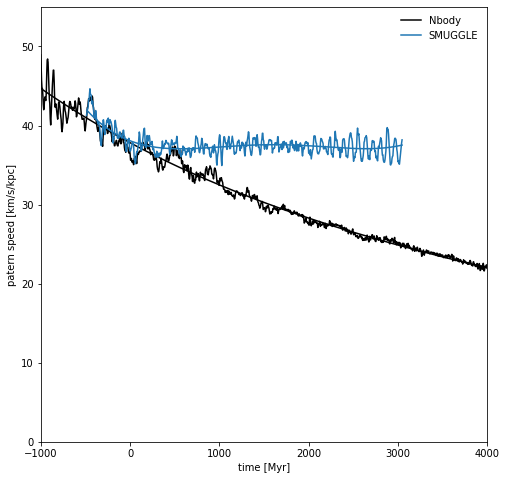

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
n=5

dat = outN
name = 'Nbody'

time = dat['time']
ba, ps = dat['poly_eval'][n]
true_ps = dat['pattern_speed']
ax.plot(time-time[400], ps, label=name, c='k')
ax.plot(time-time[400], true_ps, c='k')#, label=name)
dt = time[300] - time[400]

# dat = out3
# name = 'Sg 10'

# time = dat['time']
# ba, ps = dat['poly_eval'][n]
# true_ps = dat['pattern_speed']
# # ax.plot(time-time[0], ps, label=name)
# ax.plot(time-time[0], true_ps, label=name)

# dat = out4
# name = 'snap300'

# time = dat['time']
# ba, ps = dat['poly_eval'][n]
# true_ps = dat['pattern_speed']
# l=ax.plot(time-time[0], ps, label=name)
# ax.plot(time-time[0], true_ps, label=name, c=l[0].get_color())

dat = out6
name = 'SMUGGLE'

time = dat['time'] + dt
ba, ps = dat['poly_eval'][n]
true_ps = dat['pattern_speed']
l=ax.plot(time, ps, label=name)
ax.plot(time, true_ps, c=l[0].get_color())


dat = out6i
name = 'isotherm'

time = dat['time'] + dt
ba, ps = dat['poly_eval'][n]
true_ps = dat['pattern_speed']
# l=ax.plot(time, ps, label=name)
# ax.plot(time, true_ps, c=l[0].get_color())


ax.legend(frameon=False)

ax.set(xlim=(-1000, 4000))
# ax.set(xlim=(2500,3000))
ax.set(ylim=(0, 55), xlabel='time [Myr]', ylabel='patern speed [km/s/kpc]')
plt.show()

In [10]:
angmom5_list = []
angmom6_list= []
angmom6i_list= []
for i,idx in enumerate(tqdm(idx_list)):
    angmom5_list.append(compute_angmom(sn5_list[i], center=np.array([0, 0, 0])))
    try:
#         com = find_com(sn6_list[i], Rfac=0.6)
        com = np.array([200, 200, 200])
        angmom6_list.append(compute_angmom(sn6_list[i], center=com))
    except:
        pass
    try:
        com = np.array([200, 200, 200])
        angmom6i_list.append(compute_angmom(sn6i_list[i], center=com))
    except:
        pass
angmom5_list = np.array(angmom5_list)
angmom6_list = np.array(angmom6_list)
angmom6i_list = np.array(angmom6i_list)

A Jupyter Widget

In [11]:
time5_list = []
time6_list = []
time6i_list = []
for i,idx in enumerate(tqdm(idx_list)):
    time5_list.append(sn5_list[i].Time)
    try:
        time6_list.append(sn6_list[i].Time)
    except:
        pass
    try:
        time6i_list.append(sn6i_list[i].Time)
    except:
        pass
time5_list = np.array(time5_list)
time6_list = np.array(time6_list)
time6i_list = np.array(time6i_list)

A Jupyter Widget

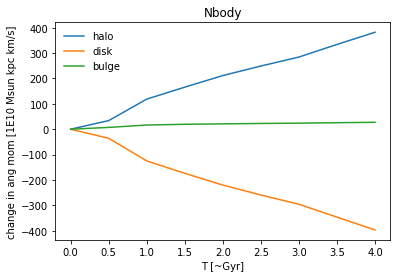

In [12]:
plt.plot(time5_list, angmom5_list[:,1,2] - angmom5_list[:,1,2][0], label='halo')
plt.plot(time5_list, angmom5_list[:,2,2] - angmom5_list[:,2,2][0], label='disk')
plt.plot(time5_list, angmom5_list[:,3,2] - angmom5_list[:,3,2][0], label='bulge')
plt.legend(frameon=False)
plt.xlabel('T [~Gyr]')
plt.ylabel('change in ang mom [1E10 Msun kpc km/s]')
plt.title('Nbody')
plt.show()

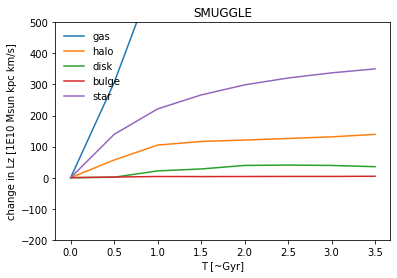

In [15]:
plt.plot(time6_list, angmom6_list[:,0,2] - angmom6_list[:,0,2][0], label='gas')
plt.plot(time6_list, angmom6_list[:,1,2] - angmom6_list[:,1,2][0], label='halo')
plt.plot(time6_list, angmom6_list[:,2,2] - angmom6_list[:,2,2][0], label='disk')
plt.plot(time6_list, angmom6_list[:,3,2] - angmom6_list[:,3,2][0], label='bulge')
plt.plot(time6_list, angmom6_list[:,4,2] - angmom6_list[:,4,2][0], label='star')
# plt.plot(time6_list, angmom6_list[:,0], label='gas')
# plt.plot(time6_list, angmom6_list[:,1], label='halo')
# plt.plot(time6_list, angmom6_list[:,2], label='disk')
# plt.plot(time6_list, angmom6_list[:,3], label='bulge')
plt.legend(frameon=False)
# plt.yscale('log')
plt.xlabel('T [~Gyr]')
plt.ylabel('change in Lz [1E10 Msun kpc km/s]')
plt.ylim(-200, 500)
plt.title('SMUGGLE')
plt.show()

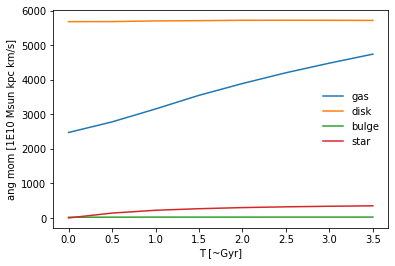

In [14]:
plt.close()

# plt.plot(time6_list, (angmom6_list[:,0] - angmom6_list[:,0][0])/angmom6_list[:,0][0], label='gas')
# plt.plot(time6_list, (angmom6_list[:,1] - angmom6_list[:,1][0])/angmom6_list[:,1][0], label='halo')
# plt.plot(time6_list, (angmom6_list[:,2] - angmom6_list[:,2][0])/angmom6_list[:,2][0], label='disk')
# plt.plot(time6_list, (angmom6_list[:,3] - angmom6_list[:,3][0])/angmom6_list[:,3][0], label='bulge')
# plt.plot(time6_list, (angmom6_list[:,4] - angmom6_list[:,4][0])/angmom6_list[:,4][0], label='star')
plt.plot(time6_list, angmom6_list[:,0,2], label='gas')
# plt.plot(time6_list, angmom6_list[:,1], label='halo')
plt.plot(time6_list, angmom6_list[:,2,2], label='disk')
plt.plot(time6_list, angmom6_list[:,3,2], label='bulge')
plt.plot(time6_list, angmom6_list[:,4,2], label='star')
plt.legend(frameon=False)

plt.xlabel('T [~Gyr]')
plt.ylabel('ang mom [1E10 Msun kpc km/s]')

# plt.yscale('log')
# plt.ylim(-0.01, 0.01)
plt.show()

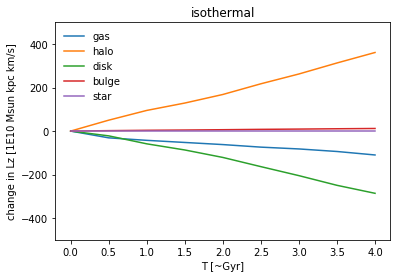

In [21]:
plt.plot(time6i_list, angmom6i_list[:,0,2] - angmom6i_list[:,0,2][0], label='gas')
plt.plot(time6i_list, angmom6i_list[:,1,2] - angmom6i_list[:,1,2][0], label='halo')
plt.plot(time6i_list, angmom6i_list[:,2,2] - angmom6i_list[:,2,2][0], label='disk')
plt.plot(time6i_list, angmom6i_list[:,3,2] - angmom6i_list[:,3,2][0], label='bulge')
plt.plot(time6i_list, angmom6i_list[:,4,2] - angmom6i_list[:,4,2][0], label='star')
# plt.plot(time6_list, angmom6_list[:,0], label='gas')
# plt.plot(time6_list, angmom6_list[:,1], label='halo')
# plt.plot(time6_list, angmom6_list[:,2], label='disk')
# plt.plot(time6_list, angmom6_list[:,3], label='bulge')
plt.legend(frameon=False)
# plt.yscale('log')
plt.xlabel('T [~Gyr]')
plt.ylabel('change in Lz [1E10 Msun kpc km/s]')
plt.ylim(-500, 500)
plt.title('isothermal')
plt.show()